In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from collections import Counter, OrderedDict
import itertools
import string
import re

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Embedding, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import wordpunct_tokenize
from nltk.stem.lancaster import LancasterStemmer

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os.path as path

/home/luca/.local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
[nltk_data] Downloading package punkt to /home/luca/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/luca/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


# Carichiamo il dataset e svolgiamo analisi preliminari per comprendere il problema

In [2]:
PATH = path.abspath("")+'/dataset/'

train_data = pd.read_csv(PATH+'train.csv')
test_data = pd.read_csv(PATH+'test.csv')
test_labels = pd.read_csv(PATH+'test_labels.csv')
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Ok, possiamo già osservare come abbiamo 6 classi di cui non per forza abbiamo un valore (non è one-hot-vector).
### Inoltre, vi è l'attributo id che ci sarà superfluo per il task di classificazione.

### Osserviamo i dati: quanti sono i commenti non toxic ?

In [3]:
notToxic = train_data[(train_data.toxic == 0) & (train_data.severe_toxic == 0) &
                      (train_data.obscene == 0) & (train_data.threat == 0) & (train_data.insult == 0) &
                      (train_data.identity_hate == 0)]
n_notToxic = len(notToxic)
#toxic = train_data[train_data.apply(lambda x: x.values() not in notToxic.values.tolist(), axis=1)]
print("Total comments: ", len(train_data))
print("Not toxic comments: ",n_notToxic)
print("Toxic comments: ", len(train_data)-len(notToxic))

Total comments:  159571
Not toxic comments:  143346
Toxic comments:  16225


### Come possiamo vedere il dataset è sbilanciato, proviamo a vedere graficamente la distribuzione delle classi

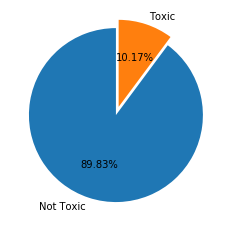

In [4]:
n_toxic = len(train_data)-len(notToxic)
dict_apple = {"Not Toxic":len(notToxic), "Toxic":n_toxic}
explode = (0, 0.1)
plt.pie(dict_apple.values(), labels=dict_apple.keys(), 
        autopct='%1.2f%%', startangle=90, explode=explode)
plt.show()

### Ora concentriamoci sui commenti Toxic

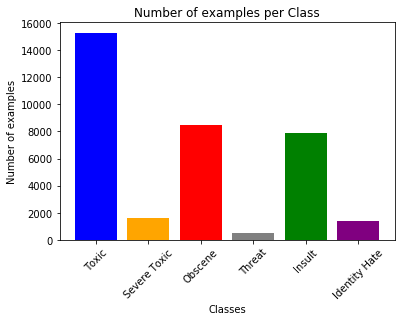

Precise values:

toxic:  15294
severe_toxic:  1595
obscene:  8449
threat:  478
insult:  7877
identity_hate:  1405


In [5]:
len_toxic = len(train_data[(train_data.toxic == 1)])
len_severe_toxic = len(train_data[(train_data.severe_toxic == 1)])
len_obscene = len(train_data[(train_data.obscene == 1)])
len_threat = len(train_data[(train_data.threat == 1)])
len_insult = len(train_data[(train_data.insult == 1)])
len_identity_hate = len(train_data[(train_data.identity_hate == 1)])
toxic_classes = {"Toxic":len_toxic, "Severe Toxic":len_severe_toxic,
                "Obscene":len_obscene, "Threat":len_threat,
                "Insult":len_insult, "Identity Hate":len_identity_hate}

plt.ylabel('Number of examples')
plt.title('Number of examples per Class')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.bar(toxic_classes.keys(), toxic_classes.values(), color=['b', 'orange', 'r', 'grey', 'g', 'purple'])
plt.show()

print("Precise values:\n")
print("toxic: ",len_toxic)
print("severe_toxic: ", len_severe_toxic)
print("obscene: ",len_obscene)
print("threat: ", len_threat)
print("insult: ", len_insult)
print("identity_hate: ", len_identity_hate)

### Osserviamo nel dettaglio quanti commenti sono associati a più classi

No handles with labels found to put in legend.


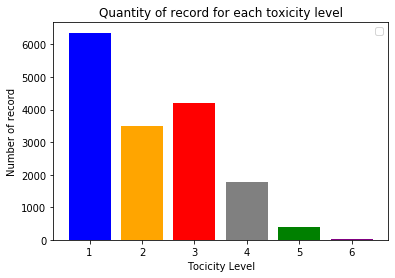

Precise values:

1 label toxic:  6360
2 labels toxic:  3480
3 labels toxic:  4209
4 labels toxic:  1760
5 labels toxic:  385
6 labels toxic:  31


In [6]:
toxicity_dict = {
    "1" : 0,
    "2" : 0,
    "3" : 0,
    "4" : 0,
    "5" : 0,
    "6" : 0,
}

for index, row in train_data.iterrows():
    toxicity_level = row['toxic'] + row['severe_toxic'] + row['obscene'] + row['threat'] + row['insult'] + row['identity_hate']
    
    if toxicity_level != 0:
        qty = toxicity_dict[str(toxicity_level)]
        qty = qty + 1
        toxicity_dict[str(toxicity_level)] = qty

toxicity_dict = OrderedDict(sorted(toxicity_dict.items()))

plt.title('Quantity of record for each toxicity level')
plt.ylabel('Number of record')
plt.xlabel('Tocicity Level')
plt.bar(toxicity_dict.keys(), toxicity_dict.values(), color = ['b', 'orange', 'r', 'grey', 'g', 'purple'])
plt.legend()
plt.show()

print("Precise values:\n")
print("1 label toxic: ",toxicity_dict["1"])
print("2 labels toxic: ", toxicity_dict["2"])
print("3 labels toxic: ",toxicity_dict["3"])
print("4 labels toxic: ", toxicity_dict["4"])
print("5 labels toxic: ", toxicity_dict["5"])
print("6 labels toxic: ", toxicity_dict["6"])

### Controlliamo ora se ci sono missing value, in tal caso rimuoviamo la riga

In [7]:
missing_data = train_data.isnull().sum().sum()
print("Number of missing data: ",missing_data)

Number of missing data:  0


### Visualizziamo le parole più frequenti per ogni categoria di tossicità

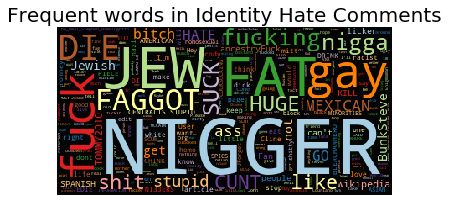

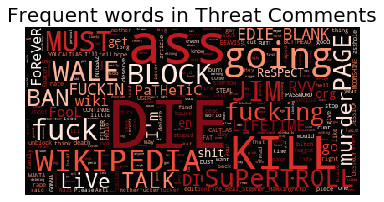

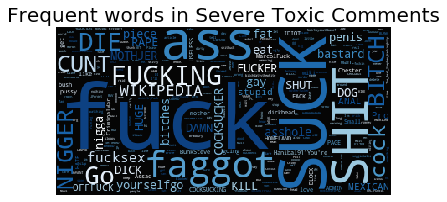

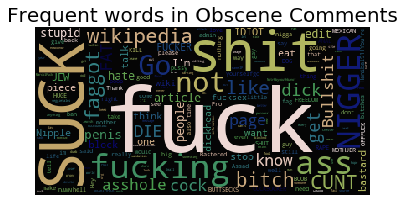

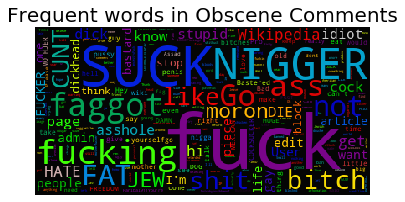

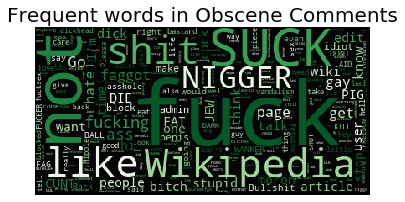

In [9]:
# Define the stopword set 
stop = stopwords.words('english')
# Let's add some new stopwords
stop = set(stop)
stop.remove("not")
stop.add("d'aww")
stop.add("\n")
stop.add("''")
stop.add("``")
stop.add("'s")
stop.add("...")
stop.add("p.s")

# Identity hate wordcloud
subset=train_data[train_data.identity_hate==1]
ih_text=subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,stopwords=stop,collocations=False)
wc.generate(" ".join(ih_text))
plt.axis("off")
plt.title("Frequent words in Identity Hate Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
plt.show()
# Threat wordcloud
subset=train_data[train_data.threat==1]
t_text=subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,stopwords=stop, collocations=False)
wc.generate(" ".join(t_text))
plt.axis("off")
plt.title("Frequent words in Threat Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)
plt.show()

# Severe toxic wordcloud
subset=train_data[train_data.severe_toxic==1]
st_text=subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,stopwords=stop, collocations=False)
wc.generate(" ".join(st_text))
plt.axis("off")
plt.title("Frequent words in Severe Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Blues' , random_state=244), alpha=0.98)
plt.show()

# Obscene wordcloud
subset=train_data[train_data.obscene==1]
st_text=subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,stopwords=stop, collocations=False)
wc.generate(" ".join(st_text))
plt.axis("off")
plt.title("Frequent words in Obscene Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)
plt.show()

# Insult wordcloud
subset=train_data[train_data.insult==1]
st_text=subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,stopwords=stop, collocations=False)
wc.generate(" ".join(st_text))
plt.axis("off")
plt.title("Frequent words in Insult Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'nipy_spectral_r' , random_state=244), alpha=0.98)
plt.show()

# Toxic wordcloud
subset=train_data[train_data.toxic==1]
st_text=subset.comment_text.values
wc = WordCloud(background_color="black",max_words=2000,stopwords=stop, collocations=False)
wc.generate(" ".join(st_text))
plt.axis("off")
plt.title("Frequent words in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Greens' , random_state=244), alpha=0.98)
plt.show()

### Estraiamo dal test set solo i commenti tossici: vogliamo definire un classificatore in grado di predirre correttamente le diverse tipologie di tossicità presenti

In [10]:
test_labels = pd.read_csv('dataset/test_labels.csv')
test_combined = pd.merge(test_data, test_labels, on=['id'])

# Now remove -1 and 0 values
test = test_combined[(test_combined.toxic == 1) | (test_combined.severe_toxic == 1) |
                      (test_combined.obscene == 1) | (test_combined.threat == 1) | (test_combined.insult == 1) |
                      (test_combined.identity_hate == 1)]
print("We have now a test set of {} only toxic comments".format(len(test)))


We have now a test set of 6243 only toxic comments


# Text preprocessing

In [11]:
# Prepare the datasets
# Shuffle the dataset
train = train_data.sample(frac=1).reset_index(drop=True)

# Extract Labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
labels = train[list_classes].values
test_labels = test[list_classes].values

# Convert to lower-case all words
text = train.comment_text
train.comment_text = list(map(lambda x: x.lower(), text))
test_text = test.comment_text
test.comment_text = list(map(lambda x: x.lower(), test_text))

# We will split train in train and val later, after the preprocessing

/home/luca/.local/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Dopo aver convertito i caratteri in minuscolo è necessario rimuovere eventuali forme contratte della lingua Inglese

In [12]:
# Remove contractions

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

# De-contract words
def clean(text):
  text = text.split(" ")
  new_text = []
  for word in text:
    if word in contractions:
      new_text.append(contractions[word])
    else:
      new_text.append(word)
  text = " ".join(new_text)
  return text

# Clean train
clean_text = []
for text in train.comment_text:
   clean_text.append(clean(text))
train.comment_text = clean_text

train_text = list(train.comment_text)

# Repeat for test
clean_text = []
for text in test.comment_text:
    clean_text.append(clean(text))
test.comment_text = clean_text

test_text = list(test.comment_text)

### Il prossimo passo è rimuovere le Stopword: lo facciamo adesso per via del Tokenizer che utilizziamo

In [13]:
# Addtional cleaning with RegEx and StopWords
stop = stopwords.words('english')
# Let's add some new stopwords
stop = set(stop)
stop.remove("not")
stop.add("d'aww")
stop.add("\n")
stop.add("''")
stop.add("``")
stop.add("'s")
stop.add("...")
stop.add("p.s")

# Apply stopword in train
for i in range(0,len(train_text)):
    train_text[i] = re.sub(r'[^\w\s]','', train_text[i])
    text = train_text[i].split()
    output = ""
    for word in text:
        if word not in stop:
            output = output + " " + word
    output = output.strip().replace("  ", " ")
    train_text[i] = output

# Repeat for test
for i in range(0,len(test_text)):
    test_text[i] = re.sub(r'[^\w\s]','', test_text[i])
    text = test_text[i].split()
    output = ""
    for word in text:
        if word not in stop:
            output = output + " " + word
    output = output.strip().replace("  ", " ")
    test_text[i] = output

### A questo punto tokenizziamo, filtrando la punteggiatura

In [14]:
# Tokenize using keras.preprocess: it will remove also the punctuation
MAX_WORDS = 200000
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(train_text)
tokenized_text = tokenizer.texts_to_sequences(train_text)
tokenized_text_test = tokenizer.texts_to_sequences(test_text)
word_indeces = tokenizer.word_index

### Utilizzando il Tokenizer di Keras, si ottiene una tokenizzazione per indici. Nella variabile word_indeces sono presenti tutti gli indici con una osservazione: più l'indice è basso e più il token è frequente nei commenti.

In [15]:
MAX_LENGTH = 200 # number of comments
x_train = pad_sequences(tokenized_text, padding='post', maxlen=MAX_LENGTH)
x_test = pad_sequences(tokenized_text_test, padding='post', maxlen=MAX_LENGTH)

## E' il momento di applicare Text Vectorization
### La tecnica scelta è GLOVe, un Word Embedding pre-trained

### Prima però, è necessario controllare il numero di vocaboli: è necessario scegliere un modello di wordEmbedding, che sia stato allenato su un numero maggiore di vocaboli.

In [16]:
# Print the number of vocabs using the number of keys in our indices dict
print(len(word_indeces))

252690


### Ok, vedendo il numero di vocaboli: 252690, possiamo utilizzare il modello di GLOVe appreso su 400mila vocaboli
### Carichiamo il modello

In [17]:
# Load Glove data
GLOVE_PATH = PATH+"glove.6B/glove.6B.200d.txt"
embeddings_index = {}
f = open(GLOVE_PATH)
print("Loading..")
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word]=np.asarray(values[1:], dtype="float32")
f.close()
print("Loaded!")

Loading..
Loaded!


### Creiamo la matrice di embedding da utilizzare nella rete neurale

In [18]:
# Create the embedded matrix
embedding_matrix = np.random.random((len(word_indeces) +1, 200))
for word, i in word_indeces.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### A questo punto definiamo il layer di input e il layer di embedding

In [19]:
# Apply the embedded matrix to our tokens
sequence_input = Input(shape=(x_train.shape[1],), dtype='int32', name='input')
embedding_layer = Embedding(len(word_indeces) + 1,
                           200,
                           weights = [embedding_matrix],
                           input_length = 200,
                           trainable=False,
                           name = 'glove')
embedded = embedding_layer(sequence_input)

### Abbiamo il nostro layer di embedded, costruiamo la Deep Neural Network

In [20]:
layer = Flatten(name='flatten')(embedded)
layer = Dense(100, activation="relu", name='hidden_1')(layer)
#layer = Dropout(0.3)(layer)
layer = Dense(50, activation="relu", name='hidden_2')(layer)
output = Dense(6, activation="sigmoid", name='output')(layer)
model = Model(sequence_input, output)

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.005, amsgrad=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            mode='min',
                                            factor=0.5, 
                                            min_lr=0.00001)

fBestModel = 'best_model.h5' 
best_model = tf.keras.callbacks.ModelCheckpoint(fBestModel, 
                                                monitor='val_fmeasure', 
                                                verbose=1, 
                                                save_best_only=True,
                                                mode='max')

### Definiamo delle metriche custom poichè la fmeasure non è prevista durante la fit

In [22]:
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def fmeasure(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Definiamo la loss function, l'optimizer e le metriche da visualizzare

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy', fmeasure])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 200)]             0         
_________________________________________________________________
glove (Embedding)            (None, 200, 200)          50538200  
_________________________________________________________________
flatten (Flatten)            (None, 40000)             0         
_________________________________________________________________
hidden_1 (Dense)             (None, 100)               4000100   
_________________________________________________________________
hidden_2 (Dense)             (None, 50)                5050      
_________________________________________________________________
output (Dense)               (None, 6)                 306       
Total params: 54,543,656
Trainable params: 4,005,456
Non-trainable params: 50,538,200
_________________________________________

### Visualizziamo il modello

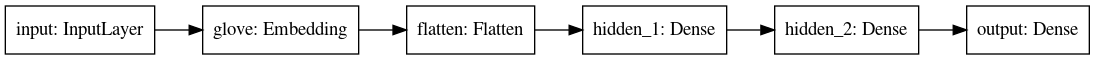

In [24]:
tf.keras.utils.plot_model(model,rankdir='LR')

### Splittiamo in train e validation e lanciamo la fit

In [25]:
print("Fase di training")
epochs = 18
batch_size = 256

x_train, x_val, y_train, y_val = train_test_split(x_train, labels, test_size=0.2, random_state=42)

history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, 
                    validation_data = (x_val, y_val), callbacks=[learning_rate_reduction, best_model])

Fase di training
(127656, 200)
(127656, 6)
(31915, 200)
(31915, 6)
Train on 127656 samples, validate on 31915 samples
Epoch 1/18
127488/127656 [============================>.] - ETA: 0s - loss: 0.6144 - accuracy: 0.9626 - fmeasure: 0.2993
Epoch 00001: val_fmeasure improved from -inf to 0.48396, saving model to best_model.h5
127656/127656 [==============================] - 97s 760us/sample - loss: 0.6137 - accuracy: 0.9626 - fmeasure: 0.2996 - val_loss: 0.0854 - val_accuracy: 0.9731 - val_fmeasure: 0.4840
Epoch 2/18
127488/127656 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9728 - fmeasure: 0.5019
Epoch 00002: val_fmeasure did not improve from 0.48396
127656/127656 [==============================] - 93s 732us/sample - loss: 0.0831 - accuracy: 0.9728 - fmeasure: 0.5016 - val_loss: 0.0844 - val_accuracy: 0.9727 - val_fmeasure: 0.4418
Epoch 3/18
127488/127656 [============================>.] - ETA: 0s - loss: 0.0766 - accuracy: 0.9744 - fmeasure: 0.5455
Epoch 000

### Non è stato utilizzato un early stop, quindi è conveniente caricare i pesi migliori, settati sul valore più alto di fmeasure

In [26]:
# Now we load the weights obtained in the lowest validation loss configuration
model.load_weights('best_model.h5')

### Visualizziamo l'andamento dell'apprendimento

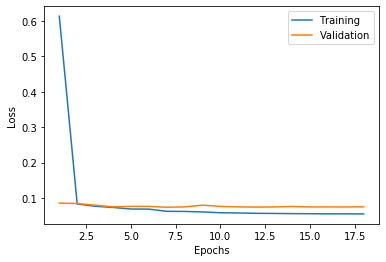

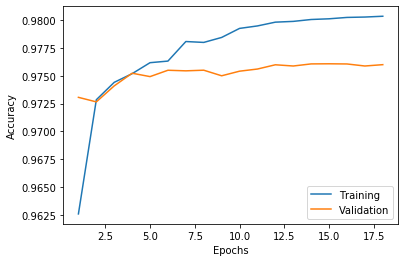

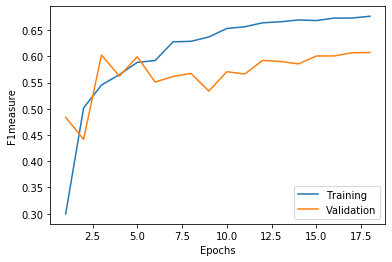

In [27]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('F1measure')
    plt.plot(x_plot, network_history.history['fmeasure'])
    plt.plot(x_plot, network_history.history['val_fmeasure'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

# Show the plots
x_plot = list(range(1,19)) #cambio con batch+1
plot_history(history)

### A questo punto siamo pronti per testare le capacità del modello con il test set composto da soli commenti tossici

In [28]:
# Test the model
y_pred = np.round(model.predict(x_test))

c = classification_report(test_labels, y_pred, target_names=list_classes)
print(c)

               precision    recall  f1-score   support

        toxic       0.98      0.60      0.74      6090
 severe_toxic       0.30      0.27      0.28       367
      obscene       0.84      0.54      0.66      3691
       threat       0.00      0.00      0.00       211
       insult       0.75      0.47      0.58      3427
identity_hate       0.71      0.11      0.18       712

  avg / total       0.85      0.51      0.63     14498



##### La classe Threat sembrerebbe essere davvero difficile da generalizzare, tuttavia, data la sua bassa numerosità, i risultati influiscono poco sulle performance.

In [29]:
from sklearn.metrics import precision_recall_fscore_support
score = precision_recall_fscore_support(test_labels, y_pred, average='micro')
print('Micro avg: ', score)
score = precision_recall_fscore_support(test_labels, y_pred, average=None)
for i in range(0,len(list_classes)):
    print('Classe: ',i) 
    print('Precision ',score[0][i])
    print('Recall ', score[1][i])
    print('F1 ', score[2][i])

Micro avg:  (0.8573245461903111, 0.5114498551524348, 0.6406877781137944, None)
Classe:  0
Precision  0.9845234862883518
Recall  0.5954022988505747
F1  0.7420444080630308
Classe:  1
Precision  0.29607250755287007
Recall  0.2670299727520436
F1  0.28080229226361036
Classe:  2
Precision  0.8404882154882155
Recall  0.5410457870495801
F1  0.658315477171584
Classe:  3
Precision  0.0
Recall  0.0
F1  0.0
Classe:  4
Precision  0.7523234200743495
Recall  0.47242486139480594
F1  0.5803907510306506
Classe:  5
Precision  0.7142857142857143
Recall  0.10533707865168539
F1  0.1835985312117503


### I risultati del modello non sono soddisfacenti, molto probabilmente per il basso numero di record su determinate categorie. Il lungo tempo impiegato dalla rete per apprendere il modello ci convince di non applicare optimization a questa rete.
### Abbiamo due strade: applicare un processo di OVERSAMPLING alla classe di minoranza e quindi lavorare direttamente sul dataset, oppure utilizzare un pre-processing diverso, magari attraverso feature extraction da una rete pre-trained.